# Evolution of Einstein's equations

# Initial data constants definition

# Initial data , setting length of the domain and discretization


In [94]:
# Parameters
m = 1

1

In [95]:
res=m;
N=2.0^m*500.0;#2.0^m*100.0;
Xf=1.0;

dx=Xf/N;
dt=round(dx*0.4,digits=10);
Nt=100.0*2^m*10
Tf=Nt*dt; #final time

println("the final time is ", Tf)

the final time is 0.8


In [96]:
print(N)

1000.0

In [97]:
println("dx =", dx)
println("dt =", dt)
println("dx/dt =", dx/dt)
println("epsilon <= dx/dt * (1/2)^(2*2-1) = ", dx/dt*(1/2)^(2*2-1))

println("epsilon = dx/dt * (1/2)^(2*2) = ", dx/dt*(1/2)^(2*2))

println("epsilon = dx/dt * (1/2)^(2*3) = ", dx/dt*(1/2)^(2*3))

println("epsilon = dx/dt * (1/2)^(2) = ", dx/dt*(1/2)^(2))

dx =0.001
dt =0.0004
dx/dt =2.5
epsilon <= dx/dt * (1/2)^(2*2-1) = 0.3125
epsilon = dx/dt * (1/2)^(2*2) = 0.15625
epsilon = dx/dt * (1/2)^(2*3) = 0.0390625
epsilon = dx/dt * (1/2)^(2) = 0.625


In [98]:
# Setting RESOLUTION

global dir = "/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/res$res"

"/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/res1"

In [99]:
println(dx)
println(dt)

0.001
0.0004


In [100]:
epsilon=0.1##0.01#0.05; #05; #02;#0.05; #0.05; #0.05;#0.05;#0.05; #dissipation strength (-1 for backwards integration)

0.1

# Grid

In [101]:
ori=0.0;
initX1 = nothing
initX1=range(ori, stop=Xf, step=dx);

In [102]:
print(dx)
initX = range(round(ori-3.0*dx,digits=10), stop=Xf+3.0*dx, step=dx)

L=length(initX);
println("step size is  ", dx)

#T=range(dt,stop=Tf,step=dt)
T=range(0,stop=Tf-dt,step=dt)
println("the time step is ", dt)

0.001step size is  0.001
the time step is 0.0004


In [103]:
radius=zeros(L)
print(L)
print(size(initX1))
print(initX1[1001])
for i in 1:L
    radius[i]=initX[i]/(1-initX[i])
end


1007(1001,)1.0

In [104]:
include("./ScalarField.jl");

In [105]:
using Interpolations

# Initial data of m β Ψ and Ψ,x

In [106]:
using PyCall   


scipy = pyimport("scipy")
scipyinterpolate = pyimport("scipy.interpolate")


####

initphi=zeros(L);
initphibar=zeros(L);

#PHI,X

r0=0.7#0.3
sigma=0.3
A=0.1449
initphibar[4:L-3] = init_gaussian_der(initX1,r0,sigma,A)



#PHI FROM PSI,X
spl = scipyinterpolate.splrep(initX[4:L-3], initphibar[4:L-3],k=5)
phi0=0
SFconstraint_phi_new(phi0,x) = scipyinterpolate.splev(x, spl)
initphi[4:L-3] = rungekutta4(SFconstraint_phi_new,phi0,initX1)#,state_array[4:L-3,:])


#PHI
"initphi = init_gaussian(R,r0,sigma,A)"




"initphi = init_gaussian(R,r0,sigma,A)"

In [107]:
"""using Plots #showing initial data and the initial status of the horizon finder
plot(initX, [initphi initphibar], xaxis="x",title="Initial Data", labels=["init phi" "init phi,x"])"""

"using Plots #showing initial data and the initial status of the horizon finder\nplot(initX, [initphi initphibar], xaxis=\"x\",title=\"Initial Data\", labels=[\"init phi\" \"init phi,x\"])"

In [108]:
initm=zeros(L);
initbeta=zeros(L);
initpsi=zeros(L);
initpsibar=zeros(L);
state_array=[initm initbeta initpsi initpsibar initX];


#PSI
initpsi = initphi .* initX ./ (1 .- initX)
initpsi[L-3]=0
state_array[:,3]=initpsi;
state_array=ghost(state_array);


#PSI,X
initpsibar = initphibar .* initX ./ (1 .- initX) +  initphi ./ (1 .- initX) .^2
initpsibar[L-3]=0
state_array[:,4]=initpsibar;
state_array=ghost(state_array);

spl_m = scipyinterpolate.splrep(initX[4:L-3], state_array[4:L-3,1],k=4)
m_func(x) = scipyinterpolate.splev(x, spl_m)

beta_func(x) = m_func(x)

spl_psi = scipyinterpolate.splrep(initX[4:L-3], state_array[4:L-3,3],k=4)
psi_func(x) = scipyinterpolate.splev(x, spl_psi)

spl_derpsi = scipyinterpolate.splrep(initX[4:L-3], state_array[4:L-3,4],k=4)
derpsi_func(x) = scipyinterpolate.splev(x, spl_derpsi)

spl_funcs = [m_func beta_func psi_func derpsi_func]

#BETA
beta0=0
initbeta[4:L-3]=rk4wrapper(SFconstraint_beta,beta0,initX1,0,spl_funcs)
state_array[:,2]=initbeta;
state_array=ghost(state_array);

#M
m0=0
initm[4:L-3]=m_rk4wrapper(SFconstraint_m,m0,initX1,0,spl_funcs)
state_array[:,1]=initm;
state_array=ghost(state_array);

spl_m = scipyinterpolate.splrep(initX[4:L-3], state_array[4:L-3,1],k=4)
m_func(x) = scipyinterpolate.splev(x, spl_m)
spl_funcs[1] = m_func

spl_beta = scipyinterpolate.splrep(initX[4:L-3], state_array[4:L-3,2],k=4)
beta_func(x) = scipyinterpolate.splev(x, spl_beta)
spl_funcs[2] = beta_func

beta_func (generic function with 1 method)

In [109]:
"""using Plots #showing initial data and the initial status of the horizon finder
plot(initX, [initpsi initpsibar], xaxis="x",title="Initial Data", labels=["init psi" "init psi,x"])"""

"using Plots #showing initial data and the initial status of the horizon finder\nplot(initX, [initpsi initpsibar], xaxis=\"x\",title=\"Initial Data\", labels=[\"init psi\" \"init psi,x\"])"

In [110]:
#monitor_ratio = 1-v/rexp(-2beta)
monitor_ratio = zeros(L)
for i in 1:L
    monitor_ratio = 2*state_array[:,1]/initX[i]*(1-initX[i])
    if monitor_ratio[i]>0.6
        print(monitor_ratio[i])
    end
end

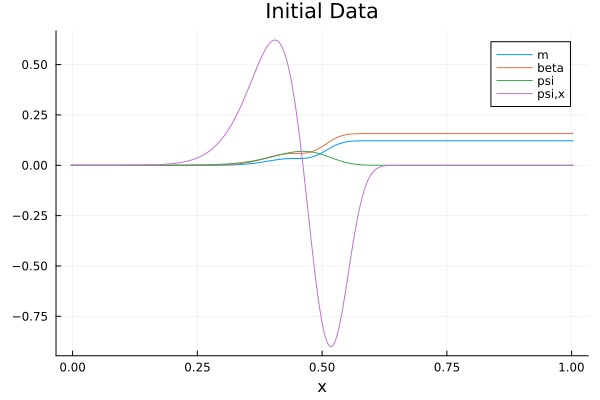

In [111]:
using Plots #showing initial data and the initial status of the horizon finder
plot(initX, state_array[:,1:4], xaxis="x",title="Initial Data", labels=["m" "beta" "psi" "psi,x"])#, xlim=[0.4, 1])

# Defining the initial state array for the evolution m β Ψ and Ψ,x

In [112]:
using CSV, Tables
CSV.write(dir*"/time_step0.csv", Tables.table(state_array), writeheader=false)

"/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/res1/time_step0.csv"

 ## Time evolution

fixed grid

In [113]:
using Interpolations
using ProgressMeter
@showprogress for k in 1:length(T)

    #evolve psi,x
    state_array=rungekutta4molstep(SF_RHS,state_array,T,k,0,spl_funcs) #evolve psi,x
    state_array=ghost(state_array)
    
    X=state_array[:,5]
    X1=X[4:L-3]
    
    spl_derpsi = scipyinterpolate.splrep(X[4:L-3], state_array[4:L-3,4],k=4)
    derpsi_func(x) = scipyinterpolate.splev(x, spl_derpsi)
    spl_funcs[4] = derpsi_func
    
    #calculate psi form psi,x
    psi0=0
    SFconstraint_psi(psi0,x) = derpsi_func(x)
    state_array[4:L-3,3] = rungekutta4(SFconstraint_psi,psi0,X1)
    state_array=ghost(state_array);
    
    spl_psi = scipyinterpolate.splrep(X[4:L-3], state_array[4:L-3,3],k=4)
    psi_func(x) = scipyinterpolate.splev(x, spl_psi)
    spl_funcs[3] = psi_func
    
    #evolve beta
    beta0=0
    state_array[4:L-3,2]=rk4wrapper(SFconstraint_beta,beta0,X1,T,spl_funcs)
    state_array=ghost(state_array)
    
    spl_beta = scipyinterpolate.splrep(X[4:L-3], state_array[4:L-3,2],k=4)
    beta_func(x) = scipyinterpolate.splev(x, spl_beta)
    spl_funcs[2] = beta_func
    
    #evolve m
    m0=0
    state_array[4:L-3,1]=m_rk4wrapper(SFconstraint_m,m0,X1,T,spl_funcs)
    state_array=ghost(state_array)
    
    spl_m = scipyinterpolate.splrep(X[4:L-3], state_array[4:L-3,1],k=4)
    m_func(x) = scipyinterpolate.splev(x, spl_m)
    spl_funcs[1] = m_func
    
    CSV.write(dir*"/time_step$k.csv", Tables.table(state_array), writeheader=false)
end

Progress:  52%|█████████████████████▍                   |  ETA: 0:18:42

LoadError: InterruptException:

changing grid

In [114]:
print(dir)

/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/res1

## Movie of the evolution

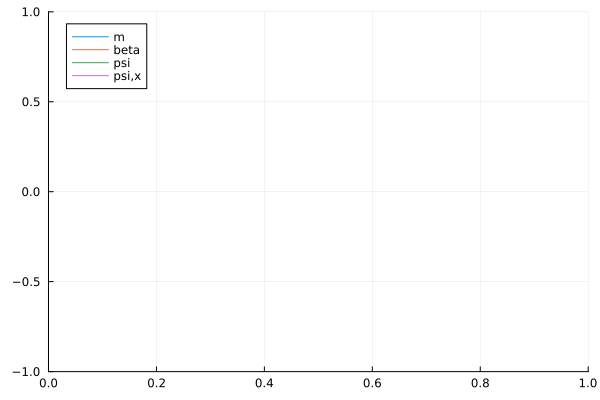

[ Info: Saved animation to /home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/anim_res1.gif


Plots.AnimatedGif("/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/anim_res1.gif")
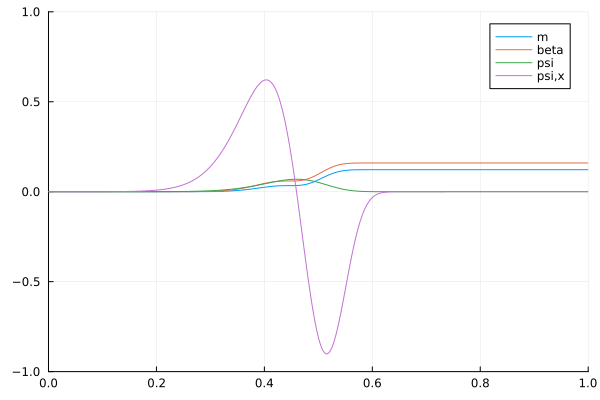

In [115]:
using Plots, CSV, DataFrames
import GR
anim = @animate for n in 10:2:1000#length(T)-1
    time_step=T[n+1]-T[n];
    IJulia.clear_output(true)
    functions3=DataFrame(CSV.File(dir*"/time_step$n.csv",header=false, delim=","))
    plot()
        plot1=functions3.Column1[4:L-3];
        plot2=functions3.Column2[4:L-3];
        plot3=functions3.Column3[4:L-3];
        plot4=functions3.Column4[4:L-3];
        plot5=functions3.Column5[4:L-3];
    d=round(T[n],digits=1)
    #plot!(X1, [plot1 plot2 plot3 plot4], labels=["m" "beta" "psi" "psi,x"],ylim=[-0.1,0.1], xlim=[0, 0.1]) |> display 
    plot!(initX[4:L-3], [plot1 plot2 plot3 plot4], labels=["m" "beta" "psi" "psi,x"],ylim=[-1,1], xlim=[0, 1]) |> display 
    
    end

gif(anim, "anim_res$res.gif", fps = 15)

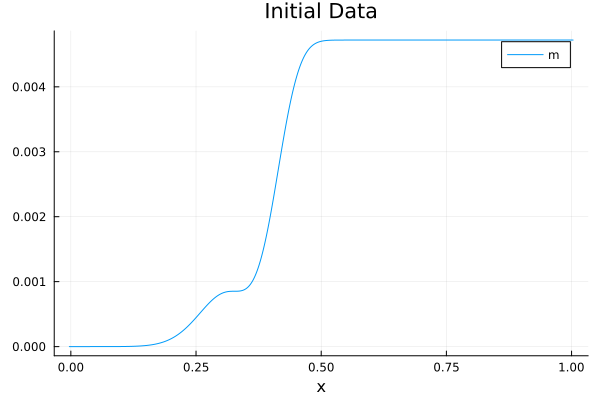

In [308]:
m0=0
initm[4:L-3]=rk4wrapper(SFconstraint_m,m0,initX1,0,spl_funcs)
state_array[:,1]=initm;
state_array=ghost(state_array);

spl_m = scipyinterpolate.splrep(initX[4:L-3], state_array[4:L-3,1],k=4)
m_func(x) = scipyinterpolate.splev(x, spl_m)
spl_funcs[1] = m_func

using Plots #showing initial data and the initial status of the horizon finder
plot(initX, ghost(initm), xaxis="x",title="Initial Data", labels=["m" "beta" "psi" "psi,x"])#, xlim=[0.4, 1])